In [5]:
import os
import nltk

import math

import matplotlib.pyplot as plt

import networkx as nx

from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud

from bs4 import BeautifulSoup
from community import community_louvain
from fa2 import ForceAtlas2

In [6]:
# Create character tuple list
import csv
import os

characters = []

with open("HP_characters.csv", "r", encoding="utf8") as sent_file:
    csv = csv.reader(sent_file, delimiter=",")
    for row in csv:
        name = row[0].replace(' ', '_')
        parentage = row[1]
        house = row[2]
        occupation = row[3]
        characters.append((name, parentage, house, occupation))

In [ ]:
# Confirm that we have a file for each character in our list
unzipped = list(list(zip(*characters))[0])
names = []

for file in os.listdir("characters"):
    names.append(file[:-4])

# The difference between the sets is the empty set
print(set(unzipped) - set(names))

In [ ]:
import os
import re
import networkx as nx

# Init graph
G = nx.DiGraph()

# Insert nodes
for character in characters:
    G.add_node(character[0], parentage=character[1], house=character[2], occupation=[3])
    
for file in os.listdir("characters"):
    orig_character = file[:-4]
    
    link_list = []
    fileopener = open("characters/" + file, 'r')
    text = fileopener.read()    
    links = re.findall(r'[[]{2}.*?[]]{2}', text)
        
    for link in links:
        character = link.replace("[", "").replace("]", "").replace(" ", "_")
        character = character.partition("|")[0]
        link_list.append(character)
    link_list = [*set(link_list)]
    
    for character in link_list:
        filename = character + ".txt"
        if os.path.isfile("characters/" + filename) or os.path.isfile("characters/" + filename):
            G.add_edge(orig_character, character)

print("Number of nodes: " + str(G.number_of_nodes()))
print("Number of edges: " + str(G.number_of_edges()))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

in_degrees = [i for (c, i) in G.in_degree]
out_degrees = [o for (c, o) in G.out_degree]

print(f"sum in_degrees = {sum(in_degrees)}")
print(f"sum out_degrees = {sum(out_degrees)}")

in_counts, in_bins = np.histogram(in_degrees)
out_counts, out_bins = np.histogram(out_degrees)

plt.plot(in_bins[:-1], in_counts, color = 'green', label='in-degrees')
plt.plot(out_bins[:-1], out_counts, color = 'red', label = 'out-degrees')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.title('In- and out-degrees')

## Communities

In [ ]:
# Making the graph undirected for the plotting
uG = G.to_undirected()

nodes = list(uG.nodes)
degrees = [d for (n,d) in list(uG.degree)]

In [ ]:
# Adjusting figure size
plt.rcParams['figure.figsize'] = [10, 10]

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2, # original 1.2
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=0.1, # original 0.5

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, nodelist = nodes, node_size=degrees, node_color="red", alpha=0.4)
nx.draw_networkx_edges(G, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.title('FA2-plot of DC/Marvel network')
plt.figtext(.5, -0.05, f"The red dots represent Marvel characters and the blue dots represents DC characters.\nThe size of a dot indicates how many links it has. The figure shows a big grouping for each of the two universes.", ha="center")

plt.show()

In [ ]:
partition = community_louvain.best_partition(uG)

In [ ]:
f = open("communities_from_fandom.csv", "w")
for character, community in list(partition.items()): 
    f.write(character + "," + str(community) + "\n")
f.close()

In [ ]:
partition_list = []
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    partition_list.append(list_nodes)
partition_list = sorted(partition_list, key=len, reverse=True)

In [ ]:
# Adjusting figure size
plt.rcParams['figure.figsize'] = [10, 10]

#drawing using ForceAtlas
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.1,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.5, # original 0.5
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=10.0,
                        strongGravityMode=True,
                        gravity=0.1,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(uG, pos=None, iterations=2000)
cmap = plt.get_cmap('plasma', max(partition.values()) + 1)

nx.draw_networkx_nodes(uG, positions, partition.keys(), node_size=40,
                        cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(uG, positions, edge_color='green', alpha=0.1)
plt.title('FA2-plot of communities')
plt.figtext(.5, 0, f"The plot contains the 10 communities found in our DC data set.\nEach community has a distinct color, edges have been colored green", ha="center")
plt.show()


In [ ]:
#Putting together the text from the pages belonging to each community
community_texts = []
maxrange = 0
#if we have less than 10 communities
if len(partition_list) < 10:
    maxrange = len(partition_list)
else:
    maxrange = 10
    
for sublist in partition_list[:maxrange]:
    com_txt = []
    for character in sublist:
        f = open("./characters/"+character+".txt")
        raw = f.read()
        tokens = nltk.wordpunct_tokenize(BeautifulSoup(raw, 'html.parser').get_text())
        file_text = [w.lower() for w in tokens if w.isalpha()]
        com_txt = com_txt + file_text
    community_texts.append(com_txt)

stopwords = nltk.corpus.stopwords.words('english')

community_strings = []
for txt in community_texts:
    com_words = [w for w in txt if w not in stopwords]
    community_strings.append(com_words)

In [ ]:
unique_terms = []
for community_words in community_strings:
    unique_terms.append(list(set(community_words)))

In [ ]:
def idf(word, unique_list):
    N = len(unique_list)
    term_appears = 0
    for sublist in unique_list:
        if word in sublist:
            term_appears+=1
    idf_val = math.log(N/(1+term_appears))+1
    return idf_val

In [ ]:
# Creating the tf list
tfidf_list = []

for community_words in community_strings:
    fdist = FreqDist(community_words)
    total_terms = len(community_words)
    tfidf=[]
    for word in fdist:
        idf_val = idf(word, unique_terms)
        tf_val = fdist[word]/total_terms
        tfidf_elem=(word, tf_val*idf_val)
        tfidf.append(tfidf_elem)
    tfidf_list.append(tfidf)


In [ ]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [15, 20]
captions = ["Gibberish 1",
            "Batman",
            "Superman",
            "Vandal Savage",
            "Teen Titans",
            "Outsiders",
            "Justice League 2",
            "Wonder Woman",
            "Green Lantern",
            "Legion of Super-Heroes"]

for i in range(len(tfidf_list)):
    ax = fig.add_subplot(5,2,i+1)
    wordcloud = WordCloud(background_color='black', width=2200,
                      height=1800, collocations=False).generate_from_frequencies(dict(tfidf_list[i]))

    ax.imshow(wordcloud)
    ax.text(0.5,-0.1, captions[i], size=12, ha="center", 
         transform=ax.transAxes)
    ax.axis('off')
plt.show()

## Temporal graphs

The function ```temporal_graph(dict, outer, inner)``` is meant to take our dictionary of characters with their aliases, and look for any matches in ```outer```, which will be a path to the text that will give us the nodes of the graph. e.g. a chapter or a book. ```ìnner``` will be path to the texts making up the text file(s) in ```outer```, for which we will be looking for links. e.g. if ```outer```is a chapter, then ```inner``` could be the pages for that chapter. 

Note: Why cant we do the same for both arguments? Then the graph will be complete, since all the characters of that chapter/book will have links to all other characters from that book, since they will be in that part together.
The idea is to get a graph of all the characters in a book, and then construct a graph for each of the chapters, this will allow us to see how the network change throughout the book.

In [ ]:
# Find the characters that appear within some boundary (chapter, book, etc)
# and link them according to those they appear along with (paragraph, page, chapter)
# To add links such that all the nodes are not just linking each other 
# the boundary for the links must be a proper subset of the boundary for the nodes (?)
# Find all sentiments for characters from aliases in a book

# inputs:
# dict_aliases: A dictionary of characters with their aliases
# path_to_bound_one: Path to the text that represents the larger boundary (chapter, book)
# path_to_bound_two: Path to the text that represents the smaller boundary (paragrah, page, chapter)
def temporal_graph(dict_aliases, path_to_bound_one, path_to_bound_two):
    # Making the dict into a list of tuples (character, aliases)
    character_aliases = list(dict_aliases.items())
    nodes_bound = os.listdir(path_to_bound_one)
    links_bound = os.listdir(path_to_bound_two)

    # Init graph
    G = nx.Graph()

    # Find all the characters that appear in the outher bound, add them as nodes
    for character, aliases in character_aliases: # For each character
        # read in text to look for nodes
        f = open(path_to_bound_one + chapter)
        raw = f.read()
        tokens = nltk.wordpunct_tokenize(raw)
        text = nltk.Text(tokens)
        character_found = False
        
        for alias in aliases: # For each alias for that character see if there is an occurence
                if alias in text:
                    character_found = True
                    break
        if character_found:# The character was in the outer bound
            G.add_node(character)
    
    # Find all the characters that are named in the same inner bound, add links between them
    for character_source, aliases_source in character_aliases: # For each character
        # read in text to look for nodes
        f = open(path_to_bound_two + chapter)
        raw = f.read()
        tokens = nltk.wordpunct_tokenize(raw)
        text = nltk.Text(tokens)
        link_found = False
        
        for alias_source in aliases_source:
            for character_target, aliases_target in character_aliases:
                if alias_source in text and alias_target in text:
                    G.add_edge(character_source, character_target)
                    break                    
    return G

In [ ]:
# Idea
#temporal_graph(dict_aliases, book7, chapter1)
#temporal_graph(dict_aliases, book7, chapter2)
# etc, to see how the network changes throughout book7

Since the graph is undirected we cannot examine the in- and out-degrees, but we can see how the number of "active" nodes and links changes. For the book example, we may see how the number of characters in each chapter changes, and how many interactions they have.

In [ ]:
# Trying to plot degrees for a list of graphs

A = nx.Graph()
A.add_edges_from([(0,1), (1,2), (2,3), (1,3)])
B = nx.Graph()
B.add_edges_from([(0,1), (1,2), (2,3), (1,3), (0, 3), (1,2)])
C = nx.Graph()
C.add_edges_from([(0,1), (1,2), (2,3), (1,3), (3,4), (3,5), (4,5)])

graphs = [A, B, C]

def plot_degrees(graph_list):
    
    # Make a tuple list of (nodes, degrees)

In [ ]:
# Assuming we have a list of graphs, by running temporal_graph on a book and all of its chapters,
# this function takes the list of graphs as an argument and plots the number of active nodes
# and the number of links

# Expected output: A graph showing the number of "active" nodes for the chapter

def plot_graph_dev(graph_list):
    
    
    

In [ ]:
def temporal_graph(dict_aliases, path_to_bound_one, path_to_bound_two):
    # Making the dict into a list of tuples (character, aliases)
    character_aliases = list(dict_aliases.items())
    nodes_bound = os.listdir(path_to_bound_one)
    links_bound = os.listdir(path_to_bound_two)

    # Init graph
    G = nx.Graph()

    # Find all the characters that appear in the outher bound, add them as nodes
    for character, aliases in character_aliases: # For each character
        # read in text to look for nodes
        f = open(path_to_bound_one + chapter)
        raw = f.read()
        tokens = nltk.wordpunct_tokenize(raw)
        text = nltk.Text(tokens)
        character_found = False
        
        for alias in aliases: # For each alias for that character see if there is an occurence
                if alias in text:
                    character_found = True
                    break
        if character_found:# The character was in the outer bound
            G.add_node(character)
    
    # Find all the characters that are named in the same inner bound, add links between them
    for character_source, aliases_source in character_aliases: # For each character
        # read in text to look for nodes
        f = open(path_to_bound_two + chapter)
        raw = f.read()
        tokens = nltk.wordpunct_tokenize(raw)
        text = nltk.Text(tokens)
        link_found = False
        
        for alias_source in aliases_source:
            for character_target, aliases_target in character_aliases:
                if alias_source in text and alias_target in text:
                    G.add_edge(character_source, character_target)
                    break                    
    return G

# Graph with weights
Making a graphs for each chapter of a book. The nodes are the characters in the book, and edges are between characters that are in the same chapter. Edges have weight corresponding to the number of times those two characters are in the same chapter. 

In [162]:
# Input: A list of character names with their aliases, 
#        an outer_bound e.g. book,
#        a list of inner_bounds e.g. chapters of the book
# Output: A list of weighted graphs

def weighted_temporal_graphs(character_list, outer_bound, inner_bounds):
    graph_list = []
    
    # Get complete text for outer
    tokens = []
    
    F = nx.Graph()
    
    for chapter in os.listdir(outer_bound):
        if "replaced" in chapter:
            with open(outer_bound + chapter) as f:
                text = f.read()
            for character in character_list:
                if character in text and character not in list(F.nodes):
                    F.add_node(character)
    
    # For each inner bound
    G = F.copy()
    for inner in os.listdir(inner_bounds): # only testing some
        if "replaced" in inner:   
            # Init a graph for that inner bound
            
            
            print(inner)

            # Get text for inner
            with open(outer_bound + inner) as f:
                text = f.read()
            
            sentences = text.split(". ")
            count_start = 0
            count_end = 20
            
            while (count_start < len(sentences)):
                current = sentences[count_start:count_end]
                current = " ".join(current)
                for character_source in list(G.nodes):
                    #print(character_source)
                    for character_target in list(G.nodes):
                        #print(character_target)
                        if character_source is character_target:
                            continue
                        elif (character_source in current and character_target in current):
                            if G.has_edge(character_source, character_target):
                                G[character_source][character_target]['weight'] += 1
                            else:
                                G.add_edge(character_source, character_target, weight=1)
                            #print("added some edge")
                count_start = count_end
                count_end += 20
    print("Done with graph")
    graph_list.append(G)
    return graph_list

In [158]:
with open("B1/replaced_ch1.txt") as f:
                text = f.read()
            
sentences = text.split(". ")
print(len(sentences))

253


In [163]:

char_list = [c for c, b, h, o in characters]

graph_list = weighted_temporal_graphs(char_list, "B1/", "B1/")

replaced_ch1.txt
replaced_ch10.txt
replaced_ch11.txt
replaced_ch12.txt
replaced_ch13.txt
replaced_ch14.txt
replaced_ch15.txt
replaced_ch16.txt
replaced_ch17.txt
replaced_ch2.txt
replaced_ch3.txt
replaced_ch4.txt
replaced_ch5.txt
replaced_ch6.txt
replaced_ch7.txt
replaced_ch8.txt
replaced_ch9.txt
Done with graph


In [164]:
# Input: a graph
# Output: A list of of the summed weights for the edges for each node,
#         this list is orderes as the list of nodes returned from graph.nodes

def get_weight_sums(graph):
    weight_sums = []
    for node in list(graph.nodes):
        sum = 0
        for source, target in list(graph.edges):
            if node is source or node is target:
                sum += graph[source][target]["weight"]
        weight_sums.append(sum)
    return weight_sums

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 4059.01it/s]


BarnesHut Approximation  took  0.11  seconds
Repulsion forces  took  0.25  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


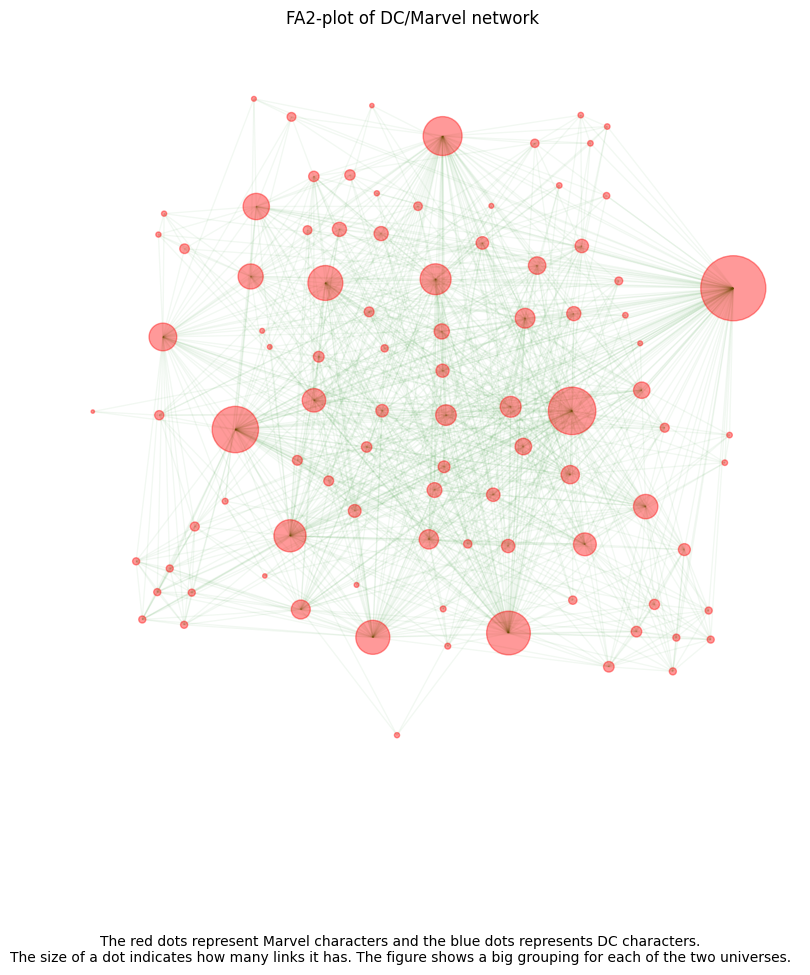

In [165]:
from fa2 import ForceAtlas2
# Adjusting figure size
plt.rcParams['figure.figsize'] = [10, 10]

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2, # original 1.2
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=0.1, # original 0.5

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(graph_list[0], pos=None, iterations=2000)
nx.draw_networkx_nodes(graph_list[0], positions, node_color="red", node_size=get_weight_sums(graph_list[0]), alpha=0.4)
nx.draw_networkx_edges(graph_list[0], positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.title('FA2-plot of DC/Marvel network')
plt.figtext(.5, -0.05, f"The red dots represent Marvel characters and the blue dots represents DC characters.\nThe size of a dot indicates how many links it has. The figure shows a big grouping for each of the two universes.", ha="center")

plt.show()